## Step 1 : Data Acquisition and Visualization

(a) Download the “MNIST” dataset and extract the files.

In [2]:
import numpy as np
import gzip
import struct

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


train_images = '/Users/nishantsingh/Documents/ML/HOMEWORK/HW4/MNIST/train-images-idx3-ubyte.gz'
train_images = read_idx(train_images)

train_labels = '/Users/nishantsingh/Documents/ML/HOMEWORK/HW4/MNIST/train-labels-idx1-ubyte.gz'
train_labels = read_idx(train_labels)

test_images = '/Users/nishantsingh/Documents/ML/HOMEWORK/HW4/MNIST/t10k-images-idx3-ubyte.gz'
test_images = read_idx(test_images)

test_labels = '/Users/nishantsingh/Documents/ML/HOMEWORK/HW4/MNIST/t10k-labels-idx1-ubyte.gz'
test_labels = read_idx(test_labels)

print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


(b) To further understand what the dataset is, you need to use the ‘matplotlib’ library to print out a
random data with code plt.imshow together with its label.(5 pts)

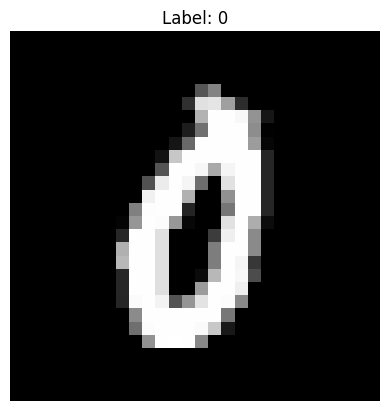

In [3]:
import matplotlib.pyplot as plt

random_index = np.random.choice(len(train_images))
plt.imshow(train_images[random_index], cmap='gray')
plt.title(f"Label: {train_labels[random_index]}")
plt.axis('off')
plt.show()

## Step 2 Data Preprocessing (10 pts):

(a) Normalize the pixel values of images to be between 0 and 1. (5 pts)

In [4]:
X_train = train_images.reshape(60000, 784) 
X_test = test_images.reshape(10000, 784)   

X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

X_train /= 255                        
X_test /= 255

X_train = X_train.T


(b) Convert the labels from categorical data into numerical values using one-hot encoding. (5 pts)

In [5]:
def one_hot(ys, num_classes):
    ohs = np.zeros((ys.shape[0], num_classes))
    for i, y in enumerate(ys):
        ohs[i][y] = 1
    ohs = ohs.T
    return ohs

# Y_train = one_hot(train_labels, num_classes=10)
# Y_test = one_hot(test_labels, num_classes=10)
# Y_train[:,0].shape

## Step 3 : Network Intialization 

(a) Identify the auxiliary input including the Sigmoid function and its derivative and Softmax function (5 pts)

In [6]:
def sigmoid (x):
    return 1/(np.exp(-x)+1)

#derivative of digmoid
def derivative_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

#derivative of softmax
def derivative_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

b) Initializing Parameters : the wieghts and parameter for layers

In [7]:
def parameters():
    np.random.seed(695)
    w1 = np.random.randn(128,784) 
    w2 = np.random.randn(64,128) 
    w3 = np.random.randn(10,64) 
    b1 = np.random.randn(128,1) 
    b2 = np.random.randn(64,1) 
    b3 = np.random.randn(10,1) 

    return w1,w2,w3,b1,b2,b3

## Step 4 Feed Forword (10 pts) :

(a) Define a function named feed_forward. Given an input x, it should output the sigmoid of wx+b

where w and b indicates the weights and bias defined in step 2. (5 pts)

In [8]:
def feed_forward(x, w1, w2, w3, b1, b2, b3):
    
    z1 = np.dot(w1, x.T) + b1
    a1 = sigmoid(z1)   

    z2 = np.dot(w2,a1) + b2
    a2 = sigmoid(z2)

    z3 = np.dot(w3,a2) + b3
    a3 = sigmoid(z3)

    return z1,a1,z2,a2,z3,a3


## Step 5 Back Propagation (15 pts): 

In [9]:
def categorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
    return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples

In [10]:
def back_propagation(z1,a1,z2,a2,a3,w2,w3,x,y):
    m = y.size
    one_hot_y = one_hot(y,num_classes=10)

    dz3 = a3 - one_hot_y
    a2 = a2.T
    dw3 = 1/m * np.dot(dz3,a2)
    db3 = 1/m * np.sum(dz3)
    
    w3 = w3.T
    dz2 = np.dot(w3, dz3) * derivative_sigmoid(z2)
    a1 = a1.T
    dw2 = 1/m * np.dot(dz2,a1)
    db2 = 1/m * np.sum(dz2)

    w2 = w2.T
    dz1 = np.dot(w2,dz2) * derivative_sigmoid(z1)
    # x = x.T
    dw1 = 1/m * np.dot(dz1,x)
    db1 = 1/m * np.sum(dz1)

    return dw1, db1, dw2, db2, dw3, db3

def update_parameter(w1,b1,w2,b2,w3,b3,dw1, db1, dw2, db2, dw3, db3, alpha):
    w1 = w1 - alpha*dw1
    b1 = b1 - alpha*db1

    w2 = w2 - alpha*dw2
    b2 = b2 - alpha*db2

    w3 = w3 - alpha*dw3
    b3 = b3 - alpha*db3

    return w1, b1, w2, b2, w3, b3    

## Step 6 Model Training (15 pts) :

(a) Use mini-batch gradient descent to update the parameters including weights and bias. 

Notice that a complete training round consists of a feed forward process, back propagation and parameter update. 

Define the batch size = 128 and epoch = 100.

In [11]:
def mini_batch_gradient_descent (x_train, y_train, batch_size, epochs):
    w1,w2,w3,b1,b2,b3 = parameters()
    alpha = 0.01
    x_train = x_train.T
    m = x_train.shape[0]
    

    for epoch in range(epochs) :
        for batch_start in range(0, m, batch_size):
            batch_end = batch_start + batch_size
            x_batch = x_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]
            

            # Forward feed
            z1,a1,z2,a2,z3,a3 = feed_forward(x_batch, w1,w2,w3,b1,b2,b3)

            # backward propogation
            dw1, db1, dw2, db2, dw3, db3 = back_propagation(z1,a1,z2,a2,a3,w2,w3,x_batch,y_batch)

            # update parameters
            w1, b1, w2, b2, w3, b3 = update_parameter(w1,b1,w2,b2,w3,b3,dw1, db1, dw2, db2, dw3, db3, alpha)

            
        
        if epoch <=100 :
            print("Iteration: ", epoch)
            predictions = get_predictions(a3)
            print(get_accuracy(predictions, y_batch))

        # if epoch  <= 100:
         #     print(f"Epoch {epoch}, Loss: {loss}")
          #    print("Iteration: ", epoch)
        #      predictions = get_predictions(a3)
         #     print(categorical_crossentropy(predictions, y_batch))    ### the code for loss calculating using crossentropy function
         # I have used the other way to get the accuracy for my understanding

         # here i noticed that before reaching the epoch limit the accuracy went up to 91 but then it drop to 89 . it was in iteration number 87
    return w1, b1, w2, b2, w3, b3


def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [12]:
w1, b1, w2, b2, w3, b3 = mini_batch_gradient_descent(X_train,train_labels, batch_size=128, epochs=100)


Iteration:  0
[2 6 8 5 6 7 9 0 6 3 1 0 1 9 3 7 2 0 6 2 9 0 8 6 9 3 1 8 1 4 0 4 7 1 7 0 9
 6 9 3 3 0 1 9 5 7 3 9 2 8 1 7 4 0 7 6 9 3 7 0 1 1 6 0 3 1 5 7 3 1 2 4 8 7
 3 1 8 3 5 7 1 2 2 0 6 3 8 8 0 0 1 7 3 9 5 8] [3 4 5 6 7 8 9 0 1 2 3 4 8 9 0 1 2 3 4 5 6 7 8 9 6 0 3 4 1 4 0 7 8 7 7 9 0
 4 9 4 0 5 8 5 9 8 8 4 0 7 1 3 5 3 1 6 5 3 8 7 3 1 6 8 5 9 2 2 0 9 2 4 6 7
 3 1 3 6 6 2 1 2 6 0 7 8 9 2 9 5 1 8 3 5 6 8]
0.2708333333333333
Iteration:  1
[2 6 8 2 6 7 1 0 6 3 3 0 1 9 3 2 2 0 2 2 2 5 8 8 5 3 1 4 1 4 0 7 8 0 7 0 9
 6 9 3 0 0 7 0 5 7 3 9 2 0 1 7 4 0 1 6 7 3 7 0 6 1 6 0 1 5 5 8 0 8 2 4 8 7
 3 1 8 3 5 0 1 2 2 0 6 3 8 8 0 0 1 7 2 9 5 8] [3 4 5 6 7 8 9 0 1 2 3 4 8 9 0 1 2 3 4 5 6 7 8 9 6 0 3 4 1 4 0 7 8 7 7 9 0
 4 9 4 0 5 8 5 9 8 8 4 0 7 1 3 5 3 1 6 5 3 8 7 3 1 6 8 5 9 2 2 0 9 2 4 6 7
 3 1 3 6 6 2 1 2 6 0 7 8 9 2 9 5 1 8 3 5 6 8]
0.3229166666666667
Iteration:  2
[2 6 8 2 7 7 1 0 6 3 3 0 1 9 3 2 2 0 4 2 2 5 8 8 5 3 1 4 4 4 0 7 8 0 7 0 9
 6 9 9 0 0 0 0 5 7 3 9 5 0 1 7 4 0 1 6 7 3 7 0 6 1 6 0 5 5 5 

## Step 7 Model Evaluation (10 pts):

(a) Use your trained neural network to predict the labels of the test dataset and compute the accuracy on the test dataset. (5 pts)

Prediction:  [7]
Label:  7


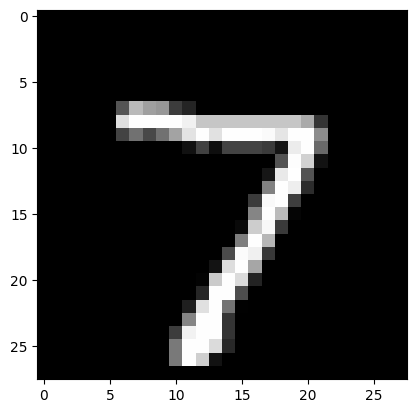

Prediction:  [2]
Label:  2


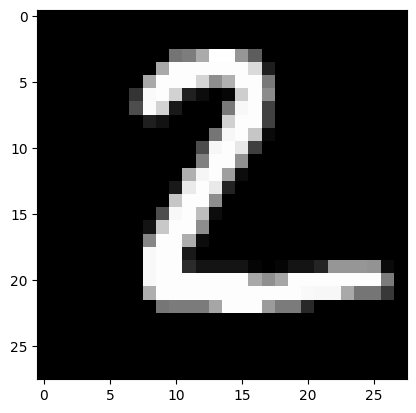

Prediction:  [1]
Label:  1


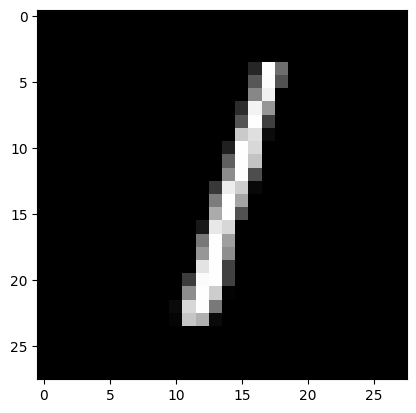

Prediction:  [0]
Label:  0


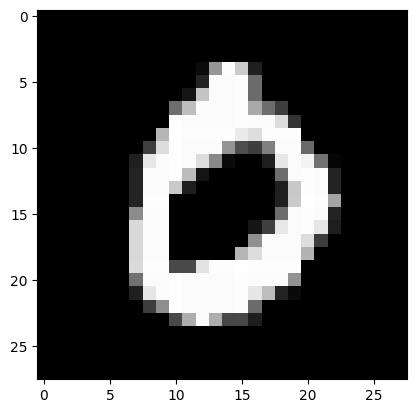

In [13]:
def make_predictions(X, w1, b1, w2, b2, w3, b3):
    X = X.T
    _,_,_,_,_,a3 = feed_forward(X,w1,w2,w3,b1,b2,b3)
    predictions = get_predictions(a3)
    return predictions

def test_prediction(index, w1, b1, w2, b2, w3, b3):
    current_image = X_test[:, index, None]
    prediction = make_predictions(X_test[:, index, None], w1, b1, w2, b2, w3, b3)
    label = test_labels[index]
    print("Prediction: ", prediction)
    print("Label: ", label)    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

X_test = X_test.T
test_prediction(0, w1, b1, w2, b2, w3, b3)
test_prediction(1, w1, b1, w2, b2, w3, b3)
test_prediction(2, w1, b1, w2, b2, w3, b3)
test_prediction(3, w1, b1, w2, b2, w3, b3)


In [14]:
def getting_accuracy(x, w1, b1, w2, b2, w3, b3):
    prediction = make_predictions(x, w1, b1, w2, b2, w3, b3)
    
    print("Prediction: ", prediction)
    print("Label: ", test_labels)
    accuracy = np.mean(prediction == test_labels) * 100
    print(f"Accuracy on the test dataset: {accuracy:.2f}%")

    return prediction
    

prediction = getting_accuracy(X_test, w1, b1, w2, b2, w3, b3)




Prediction:  [7 2 1 ... 4 5 6]
Label:  [7 2 1 ... 4 5 6]
Accuracy on the test dataset: 88.20%


(b) Plot some of the misclassified images with their predicted and true labels. (5 pts) This probably can give you some insights into why these images are misclassified.

Out of 10000 test images, these many were misclassified :-  1180


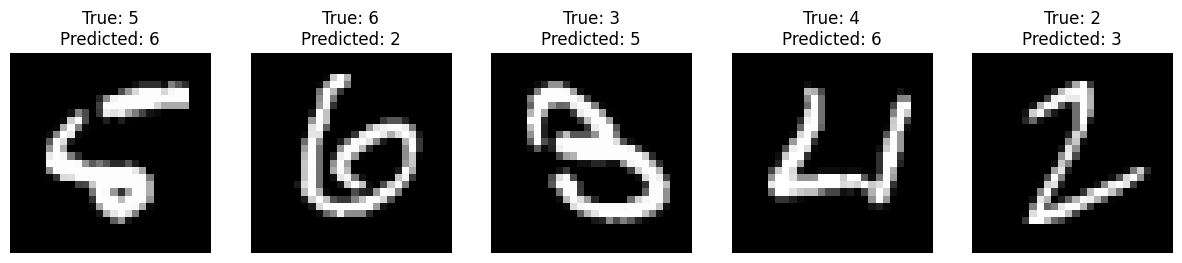

In [15]:
def missclass(prediction):

    misclassified_indices = np.where(prediction != test_labels)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified images found.")
    else:
        num_misclassified_to_plot = min(5, len(misclassified_indices))  

        plt.figure(figsize=(15, 3))

        for i in range(num_misclassified_to_plot):
            index = misclassified_indices[i]
            plt.subplot(1, num_misclassified_to_plot, i + 1)

            # Reshape the image from flattened form (784 dimensions) to 28x28
            misclassified_image = test_images[index].reshape(28, 28)

            plt.imshow(misclassified_image, cmap='gray')
            plt.title(f"True: {test_labels[index]}\nPredicted: {prediction[index]}")
            plt.axis('off')
        print ("Out of 10000 test images, these many were misclassified :- ", len(misclassified_indices))
        plt.show()

missclass(prediction)